(t = 1800 )
Training Layer:  3
Hidden Act: [ 0.0 , 0.10638014 , 1.4461167 ]
NextIn Act: [ -0.58416474 , -1.4283804e-06 , 1.0195055 ]
Test Accuracy By Layer [39.19999897480011, 36.59999966621399, 32.40000009536743]


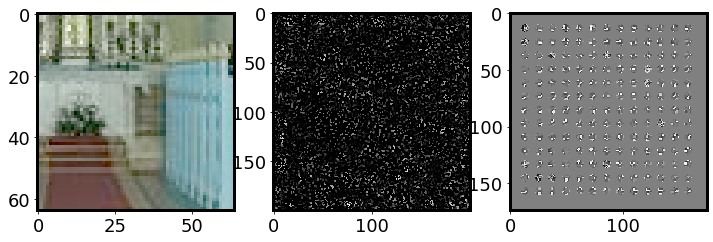

Epoch 1/15


403/403 [==============================] - 31s 70ms/step - loss: 2.2203 - accuracy: 0.1945
Epoch 2/15
403/403 [==============================] - 28s 71ms/step - loss: 2.0268 - accuracy: 0.3134
Epoch 3/15
403/403 [==============================] - 28s 70ms/step - loss: 1.8894 - accuracy: 0.3768
Epoch 4/15
403/403 [==============================] - 28s 70ms/step - loss: 1.7939 - accuracy: 0.4121
Epoch 5/15
403/403 [==============================] - 28s 71ms/step - loss: 1.7210 - accuracy: 0.4426
Epoch 6/15
403/403 [==============================] - 28s 70ms/step - loss: 1.6580 - accuracy: 0.4674
Epoch 7/15
403/403 [==============================] - 28s 70ms/step - loss: 1.6035 - accuracy: 0.4902
Epoch 8/15
403/403 [==============================] - 28s 71ms/step - loss: 1.5575 - accuracy: 0.5059
Epoch 9/15
403/403 [==============================] - 29s 71ms/step - loss: 1.5149 - accuracy: 0.5198
Epoch 10/15
403/403 [==============================] - 29s 71ms/step - loss: 1.4758 - accurac

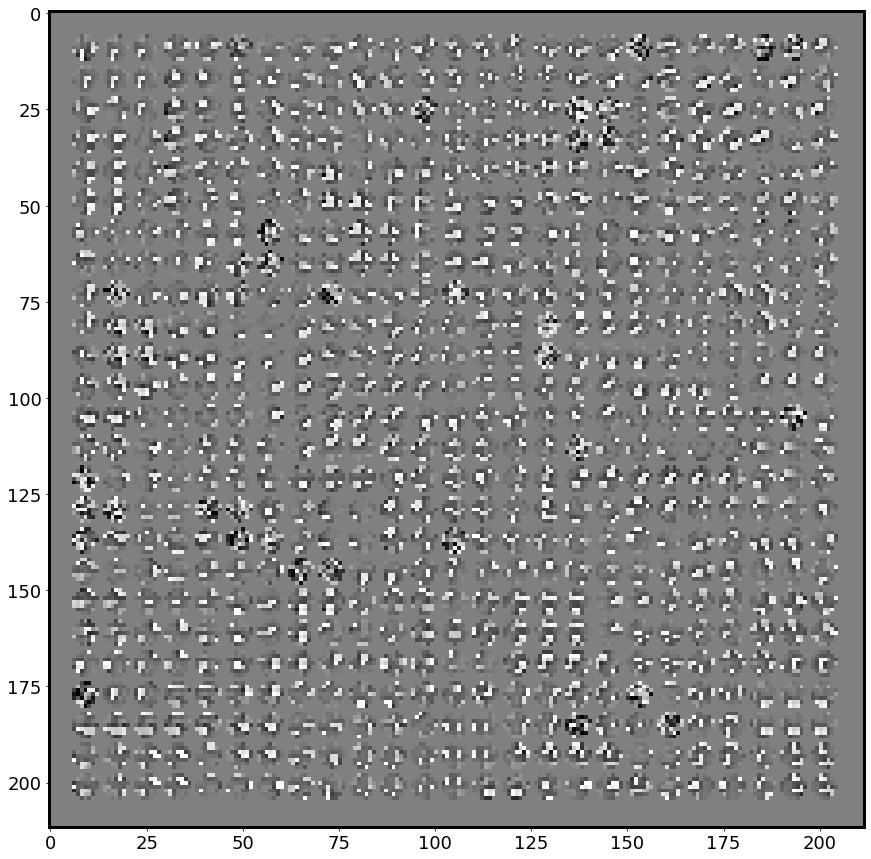

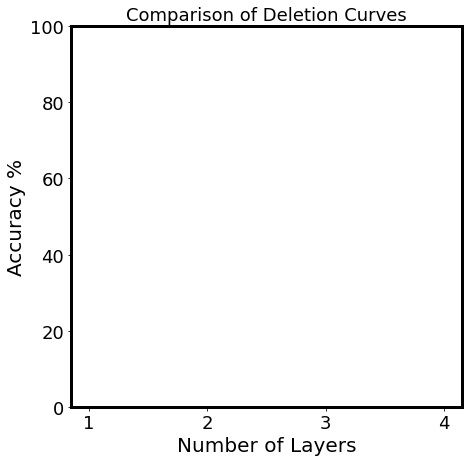

In [ ]:
%tensorflow_version 2.x
%matplotlib inline

!pip install import_ipynb # Should allow other jupiter notebooks to be loaded using import
!pip install tfa-nightly # Needed to get tensorflow image addons working (2.7.1 works)

# -*- coding: utf-8 -*-
"""
Created on Mon Nov/19/2020

@author: James Ryland

Experiment 1:
    This is an extension of experiment 1 to demonstrate that performance
generally decreses as more layers are added. For this demonstration we are
just using the SimpleOnly ICL model


For demonstration instructions see the end of the file 

"""

import import_ipynb

import ArborLayer
import SimpleICLayer as sicl

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from   tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow.keras as keras
import numpy as np
from IPython.display import clear_output

from scipy.stats import ortho_group
from scipy.ndimage import label as RegionLabel
import gc

from datetime import date
from datetime import datetime

import tensorflow_datasets as tfds


# Style for plotting
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

# Setup some basic font size thingies
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes' , linewidth =3)
plt.rc('lines', linewidth =3)
plt.rc('lines', markersize =10)

# Quick little function for getting prettier significant digits
def sigdigN(a, n):
    exp = np.floor(np.log10(a))
    return np.round(a, (-exp+n).astype(int)) 

def fileBase(quickNote):
    today = date.today()
    now = datetime.now()
    info = today.strftime("%b%d%y") +"_"+ now.strftime("%H%M")+"_"+quickNote
    return "EXP1_IMAGENETTE_ByLayer"+info


def SphereNorm(x_im, depth = 36):
    x_im = tf.nn.l2_normalize(x_im, axis=[1,2,3])
    in_ln = tf.prod(x_im.shape[1:])
    scale = tf.sqrt(1/(depth/in_ln))  
    return x_im*scale

# A bit like a gain controll layer
class WindNormLayer( layers.Layer ):

    def __init__(self, widthGau, widthCC = 1, alpha = 0.01, mult=1.0):    
        super().__init__()
        self.alpha = alpha
        self.mult = mult
        # Difference with local mean
        self.CC = sicl.CenterSurround(widthCC, widthGau)
        # Sum over local differences
        self.Gau = sicl.GaussianFilterLayer(widthGau, 12, norm=False, pad = "REFLECT")

    def call(self, in_im):
        dif = self.CC(in_im)
        var = self.Gau(tf.abs(dif))
        var = tf.nn.relu(var)   # Safety to ensure numerical approx 
                                # from gau does not leave negative numbers
        x = dif/(tf.sqrt(var)+ self.alpha)
        x = x*self.mult
        return x




class ColorEdgeLayer( layers.Layer):
    def __init__(self, widthGau, widthCC = 1):    
        super().__init__()

        # Difference with local mean
        self.Gau0 = sicl.GaussianFilterLayer(widthGau, int(widthGau*3), norm=True, pad='REFLECT')
        self.GauV = sicl.GaussianFilterLayer(widthGau, int(widthGau*3), norm=True, pad='REFLECT')
        self.Gau = sicl.GaussianFilterLayer(widthCC, int(widthCC*3), norm=True, pad='REFLECT')
        
    def call(self, in_im):
        in_im = in_im - self.Gau0(in_im)
        R = in_im[:,:,:,0,tf.newaxis]
        G = in_im[:,:,:,1,tf.newaxis]
        B = in_im[:,:,:,2,tf.newaxis]
        R_Gau = self.Gau(R)
        G_Gau = self.Gau(G)
        B_Gau = self.Gau(B)
        R_Con = R - (G_Gau+B_Gau)/2
        G_Con = G - (R_Gau+B_Gau)/2
        B_Con = B - (R_Gau+G_Gau)/2
        in_con = tf.concat((R_Con,G_Con,B_Con), axis=3)

        # Normalize differences
        var = self.GauV( (tf.abs(R_Con)+tf.abs(G_Con)+tf.abs(B_Con))/3)
        in_con = in_con/(tf.sqrt(var)+.1)

        return in_con


# Combine color contrast information with edge contrast information
class ColorSpliceLayer( layers.Layer):
    def __init__(self, colorGain= .15):    
        super().__init__()

        self.colorGain = colorGain

        # Difference with local mean
        self.MidFreq = WindNormLayer(6, widthCC = 1) # Should grab edge info
        #self.LowFreq = WindNormLayer(12, widthCC = 6) # Should grab color info
        self.LowFreq = ColorEdgeLayer(6, widthCC = 2)

    def build(self, inShape):
        rez = inShape[1]
        gInds = np.arange(0, rez, 2).astype(int) 

        X, Y = np.meshgrid(gInds,gInds, indexing='ij')
        x = np.ravel(X)[:,np.newaxis]
        y = np.ravel(Y)[:,np.newaxis]

        self.gridInds = np.concatenate( (x,y), axis = 1)
                

    def call(self, in_im):
        

        # Compute high and low frequency normalized images 
        in_im_mid = self.MidFreq(in_im)
        in_im_low = self.LowFreq(in_im)*self.colorGain

        # Change the order of the indeces for splicing WHBC
        in_im_mid = tf.transpose(in_im_mid, [1,2,0,3])
        in_im_low = tf.transpose(in_im_low, [1,2,0,3])

        # Splice them together with every 4th pixel as a low frequency pixel
        vals = tf.gather_nd(in_im_low, self.gridInds)
        in_im = tf.tensor_scatter_nd_update(in_im_mid, self.gridInds, vals)

        # Revert the order of the indices BHWC
        in_im = tf.transpose(in_im, [2,0,1,3])
        
        return in_im


def TestPreProc():

    fashion_mnist = keras.datasets.cifar10
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    #train_images = train_images[:,:,:,np.newaxis]
    #test_images = test_images[:,:,:,np.newaxis]
    train_images = train_images[:,:,:,:]
    test_images = test_images[:,:,:,:]

    # Normalize images
    train_images = (train_images/255.0).astype(np.float32)
    test_images = (test_images/255.0).astype(np.float32)


    ColorSplice = ColorSpliceLayer()
    #WindNorm = WindNormLayer(6, mult = 4.0)

    # Run the layers
    in_ims = train_images
    in_ims = ColorSplice(in_ims)
    #in_ims = WindNorm(in_ims)

    for i in range(0,10):
        print(np.mean(in_ims[i,:,:,:]))
        dispIm = in_ims[i,:,:,:]
        dispIm = (dispIm-np.min(dispIm))/(np.max(dispIm)-np.min(dispIm))
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.imshow(dispIm)


#TestPreProc()

# WOW THIS HAS A  HUGE IMPACT!!!!!!!
# But it seems incompatable with ICL learning to a degree, probably because
# of the centering behavior creating a non-zero resting point
class LCBatchNorm(layers.Layer):
    def __init__(self, beta = .01, center=True, posOnly=False):    
        super().__init__()
        self.beta = .01
        self.center = center
        self.posOnly = posOnly
    
    def build(self, inShape):
        
        paramShape = np.concatenate( ( np.ones((1),dtype=int), inShape[1:]) )

        self.alpha = self.add_weight(shape=paramShape, 
                                        initializer='ones',
                                        trainable=False)

        self.bias = self.add_weight(shape=paramShape, 
                                        initializer='zeros',
                                        trainable=False)
        
    def call(self, in_im, training=None):

        if training:
            std  = tf.math.reduce_std(in_im, axis=0)
            if self.posOnly:
                std = tf.sqrt(tf.reduce_mean( tf.abs(in_im)**2, axis = 0 ))
            mean = tf.reduce_mean    (in_im, axis=0)
            self.alpha.assign( self.alpha*(1-self.beta) + std*(self.beta) )
            self.bias.assign( self.bias*(1-self.beta) + mean*(self.beta) )

        if self.center:
            in_im = in_im-self.bias

        bn_im = (in_im)/(self.alpha+.000000000000001)

        return bn_im

class ICLNet(tf.keras.Model):

    def __init__(self, deepLearn, name=None):
        super().__init__(name=name)

        # Current training state
        self.preTrain = True 

        #self.ColorEdge = ColorEdgeLayer(1.5)
        self.ColorEdge = ColorSpliceLayer()

        #self.cc = sicl.CenterSurround(1, 4)
        self.ccICBasic = sicl.CenterSurround(1, 6)
        self.cc = WindNormLayer(6, mult = 4.0)  # 4
        self.ccIC = WindNormLayer(6, mult = 4.0) # 1 worked pretty well ! other values have actually tanked so far!
        self.BatchNorm0 = WindNormLayer(6, mult = 4.0)
        self.BatchNorm1 = WindNormLayer(6, mult = 4.0)
        self.BatchNorm2 = WindNormLayer(6, mult = 4.0)
        self.BatchNorm3 = WindNormLayer(6, mult = 4.0)
        self.BatchNorm4 = WindNormLayer(6, mult = 4.0)
        self.BatchNormOut = LCBatchNorm()

        #self.BatchNorm0 = LCBatchNorm() #center=False, posOnly=True)
        #self.BatchNorm1 = LCBatchNorm() #center=False, posOnly=True)
        #self.BatchNorm2 = LCBatchNorm() #center=False, posOnly=True)
        #self.BatchNorm3 = LCBatchNorm() #center=False, posOnly=True)
        #self.BatchNorm4 = LCBatchNorm() #center=False, posOnly=True)
        #self.BatchNormOut = LCBatchNorm() #center=False, posOnly=True)


        self.BatchNormLS = [self.BatchNorm1, self.BatchNorm2, self.BatchNorm3, self.BatchNorm4]

        #self.lat  = [[.6, 2]  , [.75, 2.2], [.8, 2.4],  [1.0, 2.6]] 
        #self.depth = [6*6, 9*9, 12*12, 12*12]

        self.lat  = [[.6, 2], [.6, 2], [.6, 2],  [.6, 2]] 
        #self.depth = [6*6, 6*6, 6*6, 6*6]
        self.depth = [6*6*3, 6*6, 6*6, 6*6]  # 6x6 seems better

        self.ICL1 = sicl.ProtoICLayer(200, self.depth[0], lat=self.lat[0], fRate=0.5, nWeight=.0) # windMult is new
        self.ICL2 = sicl.ProtoICLayer(200, self.depth[1], lat=self.lat[1], fRate=0.5, nWeight=.0)
        self.ICL3 = sicl.ProtoICLayer(200, self.depth[2], lat=self.lat[2], fRate=0.5, nWeight=.0)
        self.ICL4 = sicl.ProtoICLayer(200, self.depth[3], lat=self.lat[3], fRate=0.5, nWeight=.0)
        self.ICL_LS = [self.ICL1, self.ICL2, self.ICL3, self.ICL4]

        self.Flat = layers.Flatten()
        self.Dense1 = layers.Dense(10, activation='relu')
        self.Dense2 = layers.Dense(10, activation='relu')
        self.Dense3 = layers.Dense(10, activation='relu')
        self.Dense4 = layers.Dense(10, activation='relu')
        self.Dense_LS = [self.Dense1, self.Dense2, self.Dense3, self.Dense4]

        self.Drop = layers.Dropout(.3)

        # Output the activity image
        self.imOut = False
        self.deepLearn = deepLearn

        # set the training layer
        self.trainLayer = 0

    def call(self, x, training=None):
        
        # Normalize and center
        # Try switching!!
        #x = sicl.ItemBoxNorm(x)

        x = self.ColorEdge(x)
        #x = self.cc(x)
        #x = self.BatchNorm0(x, training=self.preTrain or training)

        if self.preTrain:
            #x = self.BatchNorm0(x, training=True)
            for l in range(0, self.trainLayer+1):
                x = self.ICL_LS[l]      (x, training=(l==self.trainLayer))
                x = self.ccIC(x)
                #x = sicl.ItemBoxNorm(x) 
                #x = self.BatchNormLS[l] (x, training=(l==self.trainLayer))
                #x = self.ccICBasic(x) # <- local contrast w/o bias is needed for ICL learning
        else:
            #x = self.BatchNorm0(x, training=training)
            for l in range(0, self.trainLayer+1):
                x = self.ICL_LS[l]      (x, training=False)
                x = self.ccIC(x)
                #x = sicl.ItemBoxNorm(x) 
                #x = self.BatchNormLS[l] (x, training=training)
                #x = self.ccICBasic(x) # <- local contrast w/o bias is needed for ICL learning

            #x = self.BatchNormLS[self.trainLayer] (x, training=training) # (This is really important for performance)
            
            # This helped a lot with the conv net!
            x = self.Drop(x)

            x = self.Flat(x)
            if not self.imOut:
                if not self.deepLearn:
                    x = tf.stop_gradient(x)
                x = self.Dense_LS[self.trainLayer](x)
        return x


class LinearNet(tf.keras.Model):

    def __init__(self, name=None):
        super().__init__(name=name)
        # Current training state 
        self.Flat = layers.Flatten()
        self.Dense = layers.Dense(10, activation=None)

    def call(self, x):
        x = self.Flat(x)
        x = self.Dense(x)
        return x


def Equiv(inRez, numLayers, ICLrez):

    filtNums = []
    inChan = 1

    for i in range(0, numLayers):
        filtNum = np.ceil((ICLrez**2)/(inRez**2*inChan))
        filtNums.append(filtNum)
        inRez = inRez/2 
        inChan = filtNum

    return filtNums

class ConvNet(tf.keras.Model):

    def __init__(self, name=None):
        super().__init__(name=name)
        # Current training state 
        self.BatchNorm0 = layers.BatchNormalization(axis=[1,2])
        self.BatchNorm1 = layers.BatchNormalization(axis=[1,2])
        self.BatchNorm2 = layers.BatchNormalization(axis=[1,2])
        self.BatchNorm3 = layers.BatchNormalization(axis=[1,2])
        self.BatchNorm4 = layers.BatchNormalization(axis=[1,2])

        # find the appropriate number of filters to roughly equalize the size
        # of the models!
        equiv = False
        filts = [8, 16, 32, 64]
        if equiv:
            filts = Equiv(64, 4, 200)
        
        print("Filt Num by Layer:", filts)

        self.Conv1 = layers.Conv2D(filts[0], 6, padding="same")
        self.Conv2 = layers.Conv2D(filts[1], 6, padding="same")
        self.Conv3 = layers.Conv2D(filts[2], 6, padding="same")
        self.Conv4 = layers.Conv2D(filts[3], 6, padding="same")
        
        self.Pool1 = layers.MaxPool2D( (2,2) )
        self.Pool2 = layers.MaxPool2D( (2,2) )
        self.Pool3 = layers.MaxPool2D( (2,2) )
        self.Pool4 = layers.MaxPool2D( (2,2) )

        self.Flat = layers.Flatten()
        self.Drop = layers.Dropout(.3)
        self.Dense = layers.Dense(10, activation=None)

    def call(self, x):
        x = self.BatchNorm0(x)
        
        x = self.Conv1(x)
        x = self.Pool1(x)
        x = self.BatchNorm1(x)

        x = self.Conv2(x)
        x = self.Pool2(x)
        x = self.BatchNorm2(x)

        x = self.Conv3(x)
        x = self.Pool3(x)
        x = self.BatchNorm3(x)

        x = self.Conv4(x)
        x = self.Pool4(x)
        x = self.BatchNorm4(x)

        x = self.Drop(x)
        x = self.Flat(x)
        x = self.Dense(x)
        
        return x

# A quick plot for the results of the experiment
def plotLayerPerf(acc_list):

    acc_list = np.array(acc_list)*100

    fig = plt.figure(figsize=[7,7])
    ax1 = fig.add_subplot(1,1,1)
    x_pos = np.arange(len(acc_list))+1
    line1 = ax1.plot( x_pos, acc_list, color="tab:red", label="Accuracy")
        
    #ax1.legend()
    ax1.set_title('Comparison of Deletion Curves')
    ax1.set_xlabel('Number of Layers')
    ax1.set_ylabel('Accuracy %')

    ax1.set_ylim([0, 100])    

    ax1.set_xticks(x_pos)
    #ax1.set_xticklabels(["Layer 1","Layer 2","Layer 3","Layer 4"], rotation=90)

    return fig

# Quick little test for a shallow ProtoICL net...
def perfPerLayer(runICL=True, runLinear=False, runConv4 = False, deeplearn=True):

    # Standard load 
    ds_train, ds_info = tfds.load(  'imagenette/160px', # Try larger version supposedly it does actually help!
                                    split='train',
                                    shuffle_files=False,
                                    as_supervised=True,
                                    with_info=True,
                                    try_gcs=True, # Get directly from colab
                                    #batch_size=-1,
                                )

    # Standard load 
    ds_test, ds_infoT = tfds.load(  'imagenette/160px',
                                    split='validation',
                                    shuffle_files=False,
                                    as_supervised=True,
                                    with_info=True,
                                    try_gcs=True, # Get directly from colab
                                    #batch_size=-1,
                                )

    # Setup a mapping form the original data shape to a standard shape
    def standardize(x, label):
        x = tf.cast(x, tf.float32)/255.0

        # Did you know digital images don't store RGB in a linear way?
        # Meaning if you don't undo the transformation many assumption around
        # color mixing and smoothing are violated?
        x = tf.sqrt(x)

        x = tf.image.resize_with_crop_or_pad(x, 64, 64)
        #label = keras.utils.to_categorical(label, 10)
        return x, label

    # Make sure nothing is being cropped for classification
    def standerdize_class(x, label):
        x = tf.cast(x, tf.float32)/255.0

        # Did you know digital images don't store RGB in a linear way?
        # Meaning if you don't undo the transformation many assumption around
        # color mixing and smoothing are violated?
        x = tf.sqrt(x)

        x = tf.image.resize_with_pad(x, 64, 64)
        #label = keras.utils.to_categorical(label, 10)
        return x, label

    labelNames = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]
    

    ds_train = ds_train.map(standardize)
    #ds_train = ds_train.batch(32, drop_remainder=True)

    ds_test = ds_test.map(standardize)
    #ds_test = ds_test.batch(20)

    # Setup Model
    model = []
    stepNum = []


    model = ICLNet(deepLearn=False)


    # Setup temporal augmentation (I think these are good settings!)
    batch = 20
    episodeLength = 10
    
    # No picker for now
    #Picker = sicl.ItemPicker(batch, train_labels, 5, 10)

    Aug =sicl.TemporalAugmentLayer(batch, episodeLength, shiftSpeed=.4, phiSpeed=.4, 
                                   speedMultiplier = .4, momentum=.99, changeEachStep=True)
    
    # Pretraining Loop
    model.preTrain = True
    
    # Number of layers
    numLayers = 4

    # Info to keep 
    test_acc_ls = []
    train_acc_ls = []

    # Write some header info
    fileName = fileBaseStr +".txt"
    file = open( fileName,"a")
    text = ""
    text = text + "NOTE:\n"
    text = text + note
    text = text + "MODEL INFO:  IMAGENETTE_SIMPLEONLY\n"
    text = text + "DeepLearn="+str(model.deepLearn)+"\n"
    text = text + "NumLayers="+str(numLayers)+"\n"
    text = text + "Lat="+str(model.lat)+"\n"
    text = text + "depth="+str(model.depth)+"\n"
    file.writelines(text) 
    file.close()

    ds_train_shuffle = ds_train.shuffle(100)


    # Get quick linear baseline
    if runLinear:
        modelLin = LinearNet()
        modelLin.compile(  tf.keras.optimizers.SGD(learning_rate=.01, momentum=.0),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                run_eagerly=False,
                metrics=['accuracy'])
        ds_train_fit = ds_train.batch(32) 
        modelLin.fit(ds_train_fit, epochs=10, batch_size=32)
        ds_test_ev = ds_test.batch(32)
        test_loss, test_acc = modelLin.evaluate(ds_test_ev, verbose=2)
        print('\nTest accuracy:', test_acc)

        file = open( fileName,"a")
        text = text + "\n\n"
        text = text + "----------------------------Linear Base Line\n"
        text = text + "Accuracy:"+str(test_acc*100)
        file.writelines(text) 
        file.close()

    if runConv4:
        modelBase = ConvNet()
        #opt = tf.keras.optimizers.SGD(learning_rate=.01, momentum=.0)
        opt = tf.keras.optimizers.Adam(learning_rate=.0001) # Experiment so far works well at .0001
        modelBase.compile(  opt,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                run_eagerly=False,
                metrics=['accuracy'])
        ds_train_fit = ds_train.batch(32) 
        modelBase.fit(ds_train_fit, epochs=100, batch_size=32)
        ds_test_ev = ds_test.batch(32)
        test_loss, test_acc = modelBase.evaluate(ds_test_ev, verbose=2)
        print('\nTest accuracy:', test_acc)

        file = open( fileName,"a")
        text = text + "\n\n"
        text = text + "----------------------------Conv 1Layer Base Line\n"
        text = text + "Accuracy:"+str(test_acc*100)
        file.writelines(text) 
        file.close()
        
    if runICL:
        # Switch which layer is training



        for l in range(numLayers):
            
            model.trainLayer = l

            for i in range(2000):
                
                # Set visualization layer
                dispICL = model.ICL_LS[model.trainLayer]

                # Pick and augment input data
                #picks = np.random.choice(train_images.shape[0], size=[batch])
                #picks = Picker()
                #in_imRaw = train_images[picks,:,:,:]

                # Should be a batched tensor/tuple (image, label)
                # See if we can make a better call for this....
                in_imRaw, labels = [], []
                for example in ds_train_shuffle.take(batch).batch(batch):
                    in_imRaw, labels = example
                
                in_imRaw = in_imRaw[:,:,:,:]
                
                in_im = Aug(in_imRaw)
                
                # Run the model on the batch
                out_im = model(in_im, training=False)
                
                
                if np.mod(i,200)==0:
                    
                    clear_output()
                    
                    print("(t =",i,")")
                    print("Training Layer: ", model.trainLayer)
                    hid = dispICL.last_Hid[0,:,:,:]
                    nextIn = out_im
                    print("Hidden Act: [", np.min(hid) ,",", np.mean(hid),",", np.max(hid) ,"]")
                    print("NextIn Act: [", np.min(nextIn) ,",", np.mean(nextIn),",", np.max(nextIn) ,"]")

                    print("Test Accuracy By Layer", test_acc_ls)

                    fig = plt.figure(figsize=[12,4])
                    ax = fig.add_subplot(1, 3, 1)
                    dispIm = in_imRaw[0,:,:,:]
                    dispIm = (dispIm-np.min(dispIm))/(np.max(dispIm)-np.min(dispIm))
                    ax.imshow(np.squeeze(dispIm), cmap='gray', interpolation='nearest')

                    ax = fig.add_subplot(1, 3, 2)
                    ax.imshow(np.squeeze(dispICL.last_Hid[0,:,:,:]), cmap='gray', interpolation='nearest')
                    
                    ax = fig.add_subplot(1, 3, 3)
                    dispIm = dispICL.Arb.projectWeights(sampleInterval=15, projectInterval=12, center=True) 
                    dispIm = (dispIm/np.max(np.abs(dispIm)))/2+.5
                    ax.imshow(np.squeeze(dispIm), cmap='gray', interpolation='nearest')

                    plt.pause(.1)

            fig = plt.figure(figsize=[15,15])
            ax = fig.add_subplot(1, 1, 1)
            dispIm = model.ICL_LS[model.trainLayer].Arb.projectWeights(sampleInterval=8, projectInterval=8, center=True) 
            dispIm = (dispIm-np.min(dispIm))/(np.max(dispIm)-np.min(dispIm))
            ax.imshow(np.squeeze(dispIm), cmap='gray', interpolation='nearest') 
            fig.savefig( fileBaseStr + "SimpleCell_BigMap.png", dpi=300 )

            # there is a memory leak in model.fit and model.evaluate
            # so we need to force python to get rid of unused variables
            gc.collect()

            # Set last layer to deep learn
            supEpochs = 15
            #if l == (numLayers-1) and deeplearn:
            #    model.deepLearn = True
            #    supEpochs = 20

            # compile sets the training paramaeters
            model.preTrain = False
            # learning rate = .005 is really good
            lRates = [.005, .01, .01, .01]
            #lRates = [.005, .005, .005, .005]
            #opt = tf.keras.optimizers.SGD(learning_rate=lRates[l], momentum=.0) # Works pretty well!
            opt = tfa.optimizers.RectifiedAdam(.0001)
            #opt = tfa.optimizers.RectifiedAdam(lr=.001, total_steps=10000, warmup_proportion=0.1, min_lr=.000001 )
            #opt = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5) # wrap adam with lookahead
            model.compile(  opt,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    run_eagerly=False,
                    metrics=['accuracy'])

            # Train the linear classifier using supervised learning
            ds_train_fit = ds_train.batch(32)             # 15
            model.fit(ds_train_fit, epochs=supEpochs, batch_size=32)

            # Evaluate the networks perforamnce on classifying the dataset
            ds_test_ev = ds_test.batch(32)
            test_loss, test_acc = model.evaluate(ds_test_ev, verbose=2)
            print('\nTest accuracy:', test_acc)
            test_acc_ls.append(test_acc*100)
            print('\nAccuracy by Layer: ', test_acc_ls)

            test_pred = model.predict(ds_test_ev)

            # Write detailed info to the file 
            #   Need to be reworded for new dataset shape...
            #   Maybe use batch and map to get the hole set of classes
            #classReportL = classification_report(np.argmax(test_pred,axis=-1), , target_names=labelNames)
            #conf = tf.math.confusion_matrix(np.argmax(test_labels,1), np.argmax(test_pred,1))
            #confReportL = np.round(conf/np.sum(conf, axis=1)*100, 0)
            
            #   Save the results of EXP1 and Record Results:
            #--------------------------------------------------
            file = open( fileName,"a")
            text = ""
            text = text + "----------------------------LAYER("+str(l+1)+") \n"
            text = text + "Test Accuracy: " + str( np.round( test_acc*100, 2)) + "% \n\n"
            #text = text + "Detailed Report: \n"
            #text = text + classReportL
            #text = text + "\nConfusion Matrix:\n"
            #text = text + str(confReportL)
            text = text + "\n\n"        
            file.writelines(text) 
            file.close()

            print(text)

            # Set the model to train again!
            model.preTrain = True

        fig = plotLayerPerf(test_acc_ls)
        fig.savefig( fileBaseStr + "_Exp1_PerLayerPerf" + ".png", dpi=300 )

#note = "writing the test"
#fileBaseStr = fileBase("Testing")
#perfPerLayer()

note = "Get Baseline Performance for Linear and Convolutional equivolent\n"
fileBaseStr = fileBase("Baseline")
perfPerLayer(runICL=True, runLinear=False, runConv4=False, deeplearn=False)


"""
DEMONSTRATION INSTRUCTIONS:
In the google colab enviornment make sure you have added the following files
to the environment:
- ArborLayer.ipynb 
- SimpleICLayer.ipynb
- SimpleComplexICLayer.ipynb

An easy way to include a file is to download the entire repository to you computer
locally, then when nescessary drag and drop the file on your computer into the
Files tab in google colab.

Also make sure that you have selected a GPU environment as this is an intensive 
simulation that will run much faster with GPU support enable. (note that 
switching to a GPU environment does not carry over included files so you will 
need to reload them)

When this is done simple recompile the file and it should go through a
demonstration of the simple only ICL model trained with 4 layers on ImageNette.

Note: Some of these simulations can take a while to run so go grab a coffee or
      Something.  
"""

